In [1]:
# Librerias basicas 
import numpy as np 
import pandas as pd 
import os
import re

# Visualizacióon
import matplotlib.pyplot as plt
import seaborn as sns 
from plotly import express as px


# Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold # Split y cross Validation
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc # Metricas
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict, GridSearchCV

# Models
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier as rfc
import xgboost as xgb

# Guardar modelos
import pickle

# Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

# Para NLP
import spacy
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from textblob import TextBlob
#import tensorflow as tf
from keybert import KeyBERT
#from bertopic import BERTopic
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from scipy import stats
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

# Estandarizar o Normalizar
from sklearn.preprocessing import StandardScaler

# Ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

#Guardado de objetos en archivos joblib
from joblib import load, dump

%matplotlib inline
pd.set_option('display.max_columns', 30)
plt.rcParams['figure.figsize'] = [12.0, 8.0]

c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Subimos dos niveles para quedar en la carpeta que contiene input y lab2-mcd-austral
BASE_DIR = './'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "dataset.csv")


In [3]:
df = pd.read_csv(PATH_TO_TRAIN, sep=';')
df

,Ejercicio,Tipo_Cpbte,N°_Entrada,Entidad_Nº,Cod_Ret,Fte_Fin.,Cuit/DniOtros,Clase_Registro,Clase_Gasto,Glosa,Sueldo
0,2021,AF,137,25,217,10,710,ANT,NaN,RES 7/21 ANTICIPO SUB. Y SUBVEN. CTA 360000200...,0
1,2021,AF,138,25,202,10,710,ANT,NaN,RES 8/21 ANT. VIATICOS Y MOVIL. CUENTA Nº3600...,0
2,2021,AF,150,50,229,10,30517999551,ANT,NaN,AFR-COMUNAS RURALES PLAN OBRAS Y SERVICIOS 2020,0
3,2021,AF,151,50,208,10,30517999551,ANT,NaN,"AFR-PLAN OBRAS, EQUIPAMIENTOS Y SERVICIOS 2020...",0
4,2021,AF,152,50,229,10,30517999551,ANT,NaN,"AFR-PLAN DE OBRAS, EQUIPAMIENTO Y SERVICIOS 2020",0
...,...,...,...,...,...,...,...,...,...,...,...
152218,2023,GE,30564,19,391,10,490,PAG,,LEY RI 2100-23 CTA 360000200973511 LEY 7991 CA...,1
152219,2023,GE,30565,19,391,10,490,PAG,,LEY RI 2099-23 CTA 360000200973511 LEY 7991 DG...,1
152220,2023,GE,30570,18,391,10,530,PAG,,R-3887-DGC-23-LEY 7991 NOV 2023 - CTA 36000020...,1
152221,2023,GE,30585,6,391,10,80,PAG,,RES-359-RO-LEY7991-HABERES DIC-3 CTA 789009,1


In [4]:
print(f"Filas {df.shape[0]} y Columnas {df.shape[1]}")

Filas 152223 y Columnas 11


In [5]:
df[['Glosa']].head(20)

,Glosa
0,RES 7/21 ANTICIPO SUB. Y SUBVEN. CTA 360000200...
1,RES 8/21 ANT. VIATICOS Y MOVIL. CUENTA Nº3600...
2,AFR-COMUNAS RURALES PLAN OBRAS Y SERVICIOS 2020
3,"AFR-PLAN OBRAS, EQUIPAMIENTOS Y SERVICIOS 2020..."
4,"AFR-PLAN DE OBRAS, EQUIPAMIENTO Y SERVICIOS 2020"
5,RES01- 1º ENTREGA COCINA-CTA360000200972235
6,D/130/SH/20-AFR-PAGO HABERES ENE/20-CTA 200982250
7,AFR-PAGO HABERES FEBRERO/20-CB-200981776-MI
8,AFR-PAGO HABERES FEBRERO/20-CB-200982250-MI
9,AFR-PAGO HABERES MARZO/2020 CTA.Nº200981776-MI


regex para texto que empieza con RES

regex para _"RES numero/numero"_

pattern = r'^RES\s\d+/\d+'

Esto significa:
- ^: Indica que el patrón debe estar al inicio de la cadena.
- RES: Busca literalmente las letras "RES".
- \s: Busca un espacio en blanco.
- \d+: Busca uno o más dígitos (números del 0 al 9).
- /: Busca el carácter "/" (barra).
- \d+: Busca uno o más dígitos (números del 0 al 9).

In [6]:
def limpiar_texto(texto):
    texto = texto.upper()
    texto = re.findall(r"(?!CTA)(?!RES)(?!PAGO)(?!AGO)[A-Z]{3,}|7991", texto)
    texto = " ".join(texto).strip()
    return texto

In [25]:
def cuentas_sueldo(texto):
    texto = texto.upper()
    texto = re.findall(r"[0-9]{5,}", texto)
    texto = " ".join(texto).strip()
    return texto

In [7]:
df["texto_limpio"] = df["Glosa"].apply(limpiar_texto)
df["texto_limpio"].tail(20)

152203                         LEY DICIEMBRE
152204                    COMPL APRESTAM DIC
152205                      LEY 7991 DIC GOB
152206                   LEY 7991 ESCRIBANIA
152207                              LEY 7991
152208                          LEY LEY 7991
152209                SLI LEY 7991 DICIEMBRE
152210                 LEY 7991 PERS MSP DIC
152211                              LEY 7991
152212                      DRI LEY 7991 NOV
152213                 SUELDO NOV ABACA SEBA
152214               LEY 7991 NOV ABACA SEBA
152215                         MOVILIDAD DGR
152216                             LEY SERIE
152217    ESTITUCION HAB JUAREZ SARA YOLANDA
152218                  LEY LEY 7991 CAP FED
152219                      LEY LEY 7991 DGR
152220                      DGC LEY 7991 NOV
152221                  LEY 7991 HABERES DIC
152222                      LEY 7991 HAB DIC
Name: texto_limpio, dtype: object

In [26]:
df["cuentas_sueldo"] = df["Glosa"].apply(cuentas_sueldo)
df["cuentas_sueldo"].tail(20)

152203     36000020097302
152204     36000020097424
152205     36000020097222
152206    360000200972228
152207    360000200978936
152208    360000003263754
152209    362200200005272
152210    360000200973115
152211              97426
152212     36000020097316
152213     36000020097300
152214     36000020097300
152215    360000200973504
152216    360000003285363
152217    360000200973511
152218    360000200973511
152219    360000200973511
152220     36000020097385
152221             789009
152222    360000200983222
Name: cuentas_sueldo, dtype: object

In [8]:
wc = WordCloud(' '.join(df[df["Sueldo"]==1]['texto_limpio']))

In [9]:
def cloud(data, backgroundcolor = 'black', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3748\3711082745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sueldo['NER_NER'] = df_sueldo['texto_limpio'].apply(lambda x : str(x or ""))


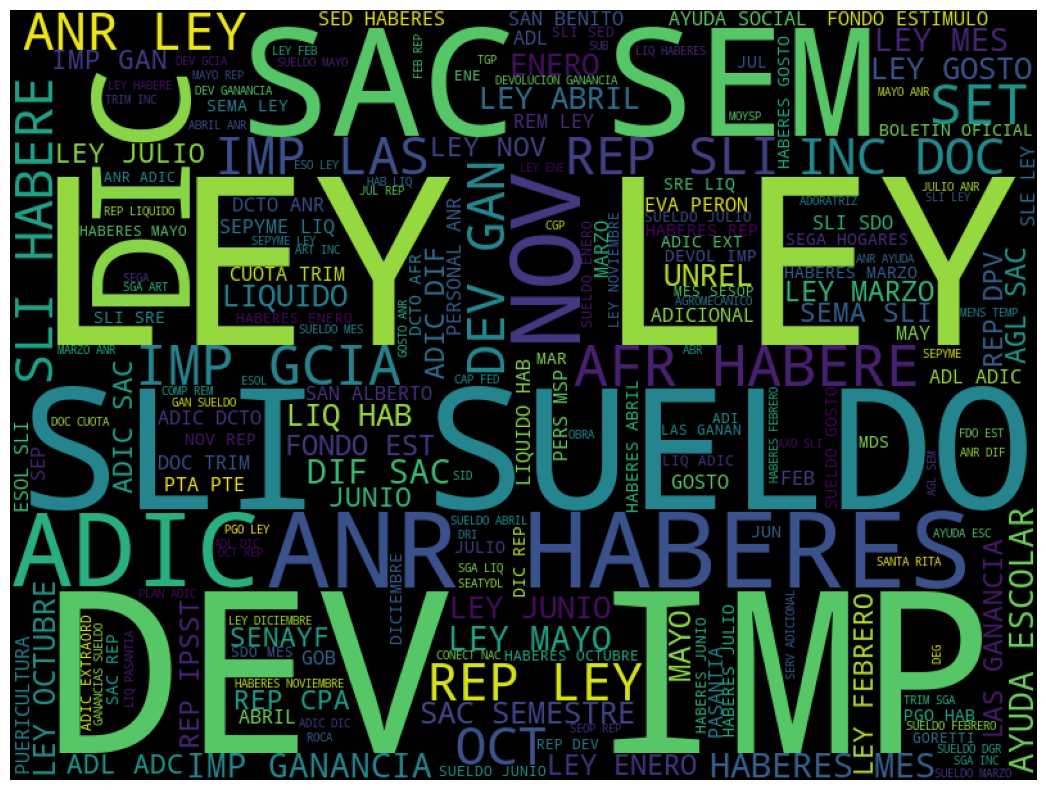

In [10]:
df_sueldo = df[df["Sueldo"]==1]
df_sueldo['NER_NER'] = df_sueldo['texto_limpio'].apply(lambda x : str(x or ""))
df_sueldo = df_sueldo[df_sueldo['NER_NER'] != 'nan']
cloud(' '.join(df_sueldo['NER_NER']))

In [11]:
# Obtener todas las descripciones como una lista de palabras
all_descriptions = ' '.join(df_sueldo['texto_limpio'].dropna())  # Concatenar todas las descripciones

# Tokenización y eliminación de stopwords
stop_words = set(stopwords.words('spanish')) 
word_tokens = word_tokenize(all_descriptions.lower())  # Tokenización y convertir a minúsculas
filtered_words = [word for word in word_tokens if word.isalnum() and word not in stop_words]  # Filtrar stopwords y no palabras alfa
freq_of_words = pd.Series(filtered_words).value_counts()

print(freq_of_words.head(50))  # Mostrar las 20 palabras más frecuentes

ley          5048
7991         3494
sli          2860
rep          1872
haberes      1712
adic         1684
sueldo       1431
anr          1376
sac          1290
dev          1232
imp           981
dic           911
mes           888
liq           850
hab           848
mayo          774
nov           730
gosto         677
sem           675
adl           672
abril         655
junio         629
marzo         594
julio         570
dcto          562
enero         559
dif           542
liquido       520
afr           513
sga           502
ayuda         473
ganancias     463
octubre       440
febrero       424
gan           419
adicional     409
gcias         406
set           386
feb           385
oct           368
sdo           368
ene           346
doc           326
noviembre     323
sema          313
jul           308
inc           305
sre           304
trim          301
fondo         300
Name: count, dtype: int64


In [31]:
df_cuentas = df[df['Sueldo']==1].copy()
# Obtener todas las descripciones como una lista de palabras
all_descriptions = ' '.join(df_cuentas['cuentas_sueldo'].dropna())  # Concatenar todas las descripciones

# Tokenización y eliminación de stopwords
stop_words = set(stopwords.words('spanish')) 
word_tokens = word_tokenize(all_descriptions.lower())  # Tokenización y convertir a minúsculas
filtered_words = [word for word in word_tokens if word.isalnum() and word not in stop_words]  # Filtrar stopwords y no palabras alfa
freq_of_words_cuentas = pd.Series(filtered_words).value_counts()

print(freq_of_words_cuentas.head(50))  # Mostrar las 20 palabras más frecuentes

978806             722
360000200973290    563
360000200983161    473
360000200983192    398
360000200973511    295
36000020097229     224
360000200973573    211
360000200983222    192
36000020097302     191
360000200972471    189
97110              185
36000020097222     183
36000020097293     179
36000020097300     178
36000020097556     175
98041              171
360000200984669    159
360700200033675    158
973276             157
36000020097846     154
36000020097291     154
360000200973757    152
362809419679986    151
1123687            149
360000200983239    145
36000020097303     143
36000020097295     142
36000020097385     142
360000200980995    140
36000020097305     140
36000020097198     139
360000200979175    139
36000020097316     135
360000003263723    133
360000200981110    131
97426              123
360000200983178    121
362809419898127    119
36000020097919     118
36000020098119     118
362200200005272    115
360000200972228    115
98382              114
36000020097

In [13]:
dic_words = freq_of_words.to_dict()

def pesos(texto):
    texto = texto.lower()
    palabras = texto.split(' ')
    score = 0
    for palabra in palabras:
        if palabra in dic_words.keys():
            score += dic_words[palabra]
            #print(palabra)
    return score

In [32]:
dic_words = freq_of_words_cuentas.to_dict()

def pesos_cuentas(texto):
    palabras = texto.split(' ')
    score = 0
    for palabra in palabras:
        if palabra in dic_words.keys():
            score += dic_words[palabra]
            #print(palabra)
    return score

In [14]:
df['pesos'] = df['texto_limpio'].apply(pesos)

In [33]:
df['pesos_cuentas'] = df['cuentas_sueldo'].apply(pesos_cuentas)

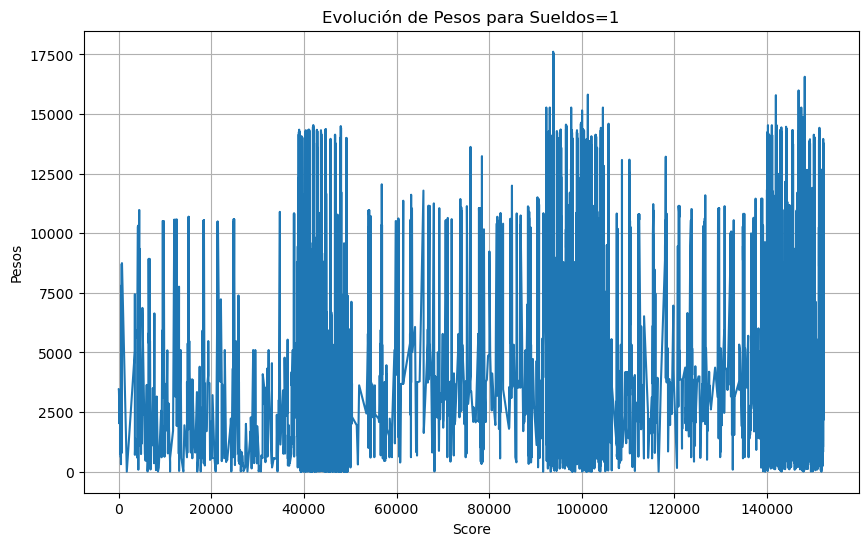

In [17]:
df_filtrado = df[df['Sueldo'] == 1]

# Crear el gráfico de línea
plt.figure(figsize=(10, 6))
plt.plot(df_filtrado.index, df_filtrado['pesos'])

# Añadir títulos y etiquetas
plt.title('Evolución de Pesos para Sueldos=1')
plt.xlabel('Fila')
plt.ylabel('Pesos')

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [18]:
df.groupby('Sueldo').sum('pesos').plot

,Ejercicio,N°_Entrada,Entidad_Nº,Cod_Ret,Fte_Fin.,Cuit/DniOtros,pesos
Sueldo,,,,,,,
0,271250884,6934298759,3950728,16669294,224426969,2184661843069819,71543929
1,36540826,346904079,504791,6217903,19371142,76932261923615,77422974


In [34]:
df.to_csv('dataset_pesos.csv', sep=';')